# **10x Visium colon data: comparison between the original and unrolled coordinate results**

This notebook reproduces the figures present in Fig S7.

In [1]:
import harreman
import os
import json
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from scipy.stats import pearsonr, wilcoxon, mannwhitneyu, ranksums, spearmanr
import random
import scipy.stats as stats
from sklearn import linear_model
from scipy.stats import hypergeom, zscore, norm
from statsmodels.stats.multitest import multipletests
from sklearn.neighbors import NearestNeighbors
from plotnine import *
from matplotlib.patches import Patch
from scipy.cluster.hierarchy import fcluster
import warnings
warnings.filterwarnings("ignore")


BASE_PATH = "/home/projects/nyosef/oier/Harreman_files/Visium_colon"
ADATA_PATH = os.path.join(BASE_PATH, 'h5ads')
DATA_PATH = os.path.join(BASE_PATH, 'data')
PLOTS_PATH = os.path.join(BASE_PATH, 'plots')

## Load dataset

Load the AnnData file and create the Hotspot object.

In [2]:
adata = ad.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_adata.h5ad'))

Filter out genes expressed in less than 50 spots per sample

In [3]:
sample_col = 'cond'
n_genes_expr = 50
genes_to_keep = np.zeros(adata.shape[1], dtype=bool)

for sample in adata.obs[sample_col].unique():
    adata_sample = adata[adata.obs[sample_col] == sample]
    expressed = np.array((adata_sample.X > 0).sum(axis=0)).flatten()
    genes_to_keep |= expressed >= n_genes_expr

adata = adata[:, genes_to_keep]

## Hotspot analysis

To start an analysis, unlike the original Hotspot algorithm, it's not necessary to create a Hotspot object since all the outputs are stored inside the AnnData object used as input.

Firstly, we compute the neighborhood graph using the *compute_knn_graph* function. For this, we need to specify the latent (or observed) space we are using to compute our cell metric with the *compute_neighbors_on_key* parameter. Further, only one of *compute_neighbors_on_key* or *distances_obsp_key* is needed in order to run the function. Similarly, either the *neighborhood_radius* or the *n_neighbors* parameter needs to be used (the former needs to contain information in micrometers). The *sample_key* parameter is optional and is only required when more than one sample are present in the AnnData and we want to avoid having neighbors from different samples. Lastly, the *tree* parameter is only needed when dealing with lineage tracing data.

Here we set *weighted_graph=False* to just use binary, 0-1 weights and *neighborhood_radius=200* to create a local neighborhood with a radius of 200 micrometers. Larger neighborhood sizes can result in more robust detection of correlations and autocorrelations at a cost of missing more fine-grained, smaller-scale, spatial patterns. Further, set *sample_key='day'* to make sure there are no shared neighbors between samples.

In [4]:
harreman.tl.compute_knn_graph(adata, 
                           compute_neighbors_on_key="spatial", 
                           neighborhood_radius=150,
                           weighted_graph=False,
                           sample_key='cond',
                           verbose=True)

Computing the neighborhood graph...
Restricting graph within samples using 'cond'...


100%|██████████| 2/2 [00:00<00:00, 46.82it/s]

Computing the weights...
Finished computing the KNN graph in 0.825 seconds


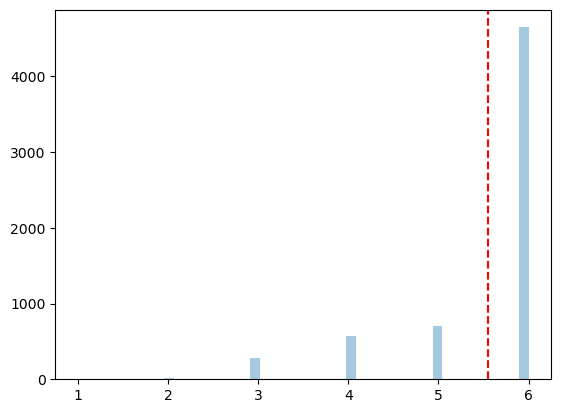

In [5]:
sns.distplot(adata.obsp['weights'].sum(axis=1).A1, kde=False)
plt.axvline(np.mean(adata.obsp['weights'].sum(axis=1).A1), color='red', linestyle='--')
# plt.savefig(os.path.join(PLOTS_PATH, 'n_neighbors_histplot.svg'))

Once the neighborhood graph is computed, local autocorrelation needs to be assessed using the *compute_local_autocorrelation* function. For this, we need to specify the gene counts matrix (with the *layer_key* parameter), which background model to use (with the *model* parameter), the species the dataset corresponds to (with the *species* parameter), the per-cell scaling factor (with the *umi_counts_obs_key* parameter), the genes we want to focus on for this analysis (with the *genes* parameter), and whether we want to focus on metabolic genes or not (with the *use_metabolic_genes* parameter).

Here we are focusing on the metabolic genes from mouse and we are using the negative binomial distribution to model our count data.

In [6]:
harreman.hs.compute_local_autocorrelation(adata, layer_key="counts", model='danb', species='mouse', use_metabolic_genes=True)

We only use those genes with a significant autocorrelation (FDR < 0.01) for the subsequent analysis.

In [7]:
gene_autocorrelation_results = adata.uns['gene_autocorrelation_results']
genes = gene_autocorrelation_results.loc[gene_autocorrelation_results.Z_FDR < 0.01].sort_values('Z', ascending=False).index

To get a better idea of what spatial patterns exist, it is helpful to group the genes into modules.

Hotspot does this using the concept of “local correlations” - that is, correlations that are computed between genes between cells in the same neighborhood.

Here we avoid running the calculation for all Genes x Genes pairs and instead only run this on genes that have significant spatial autocorrelation to begin with.

The method *compute_local_correlation* returns a Genes x Genes matrix of Z-scores for the significance of the correlation between genes. This object is also retained in the AnnData object and is used in the subsequent steps.

In [8]:
harreman.hs.compute_local_correlation(adata, genes=genes, verbose=True)

Computing pair-wise local correlation on 737 features...
Pair-wise local correlation results are stored in adata.uns with the following keys: ['lcs', 'lc_zs', 'lc_z_pvals', 'lc_z_FDR']
Finished computing pair-wise local correlation in 0.328 seconds


Now that pair-wise local correlations are calculated, we can group genes into modules.

To do this, the *create_modules* function is used, which performs agglomerative clustering with two caveats:

If the FDR-adjusted p-value of the correlation between two branches exceeds fdr_threshold, then the branches are not merged.

If two branches are to be merged and they both have at least *min_gene_threshold* genes, then the branches are not merged. Further genes that would join to the resulting merged module (and are therefore ambiguous) either remain unassigned (if *core_only=True*) or are assigned to the module with the smaller average correlations between genes, i.e. the least-dense module (if *core_only=False*). Unassigned genes are indicated with a module number of -1.

In [9]:
harreman.hs.create_modules(adata, min_gene_threshold=20)

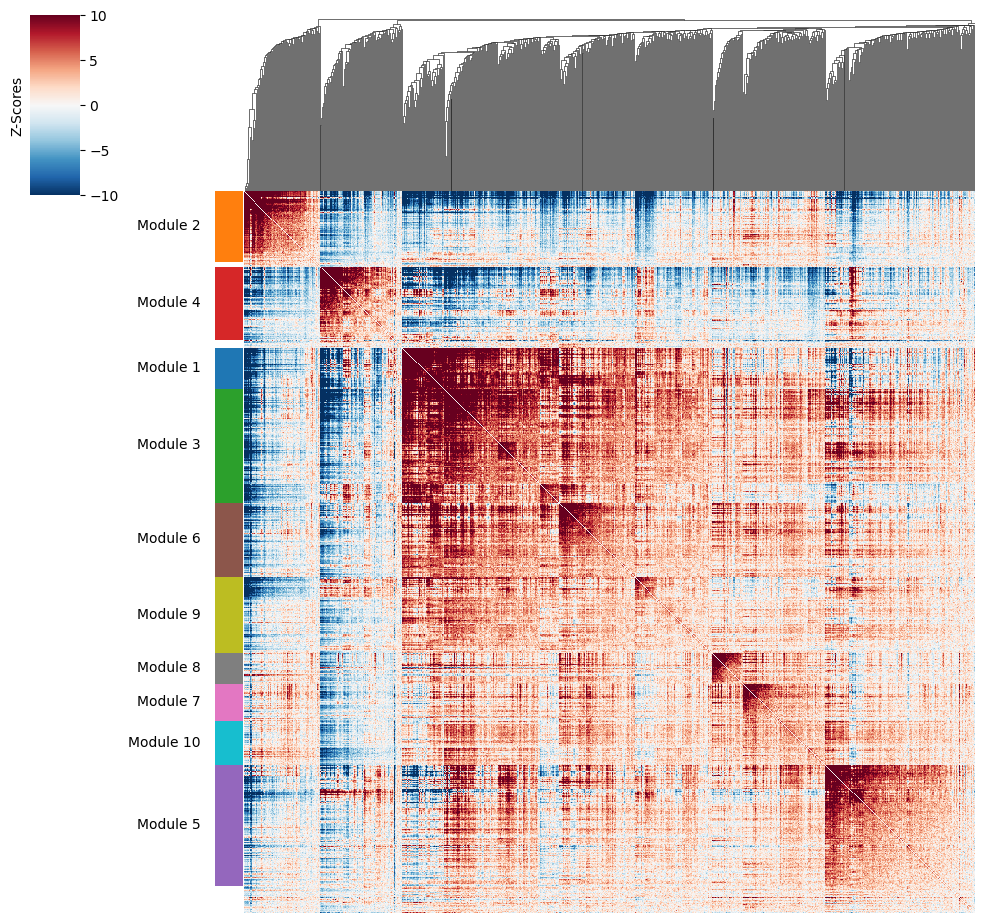

In [10]:
harreman.pl.local_correlation_plot(adata)

The function below computes the average local correlation Z to visualize modules that have high correlation between them.

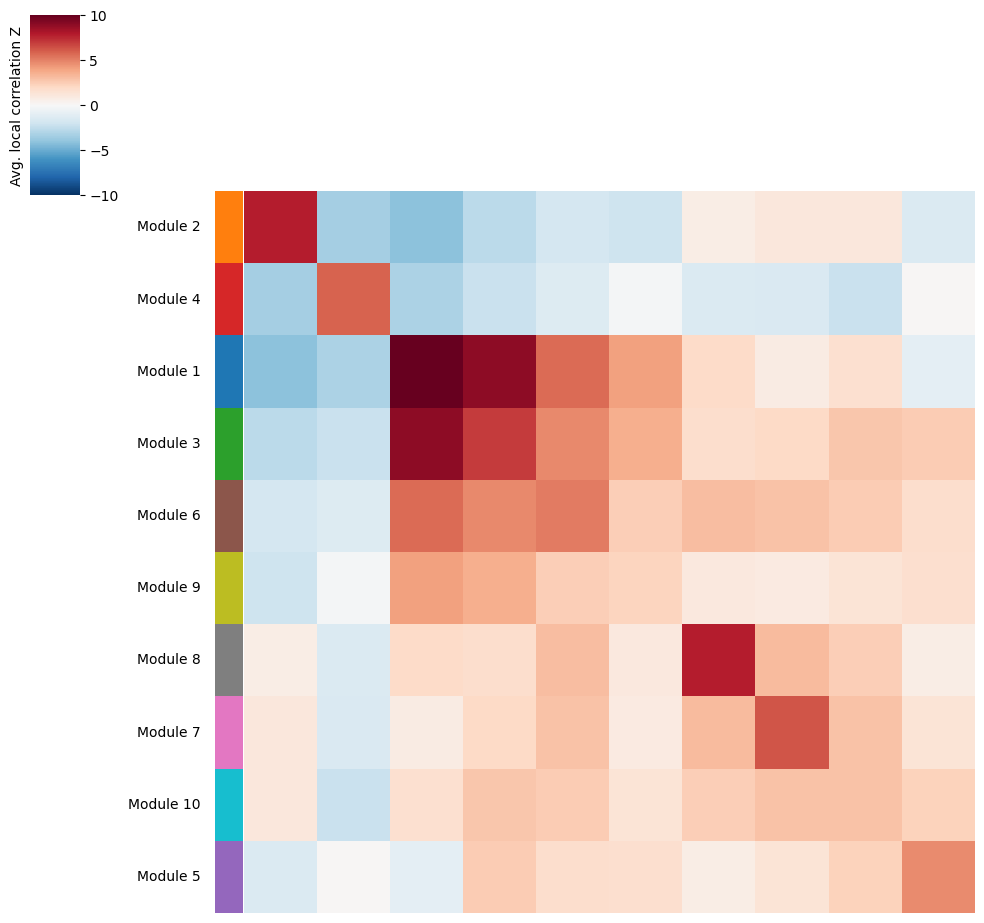

In [11]:
harreman.pl.average_local_correlation_plot(adata, col_cluster=False, row_cluster=False)

To aid in the recognition of the general behavior of a module, Hotspot can compute aggregate module scores.

In [12]:
harreman.hs.calculate_module_scores(adata)

100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


In [13]:
modules = adata.obsm['module_scores'].columns
adata.obs[modules] = adata.obsm['module_scores']

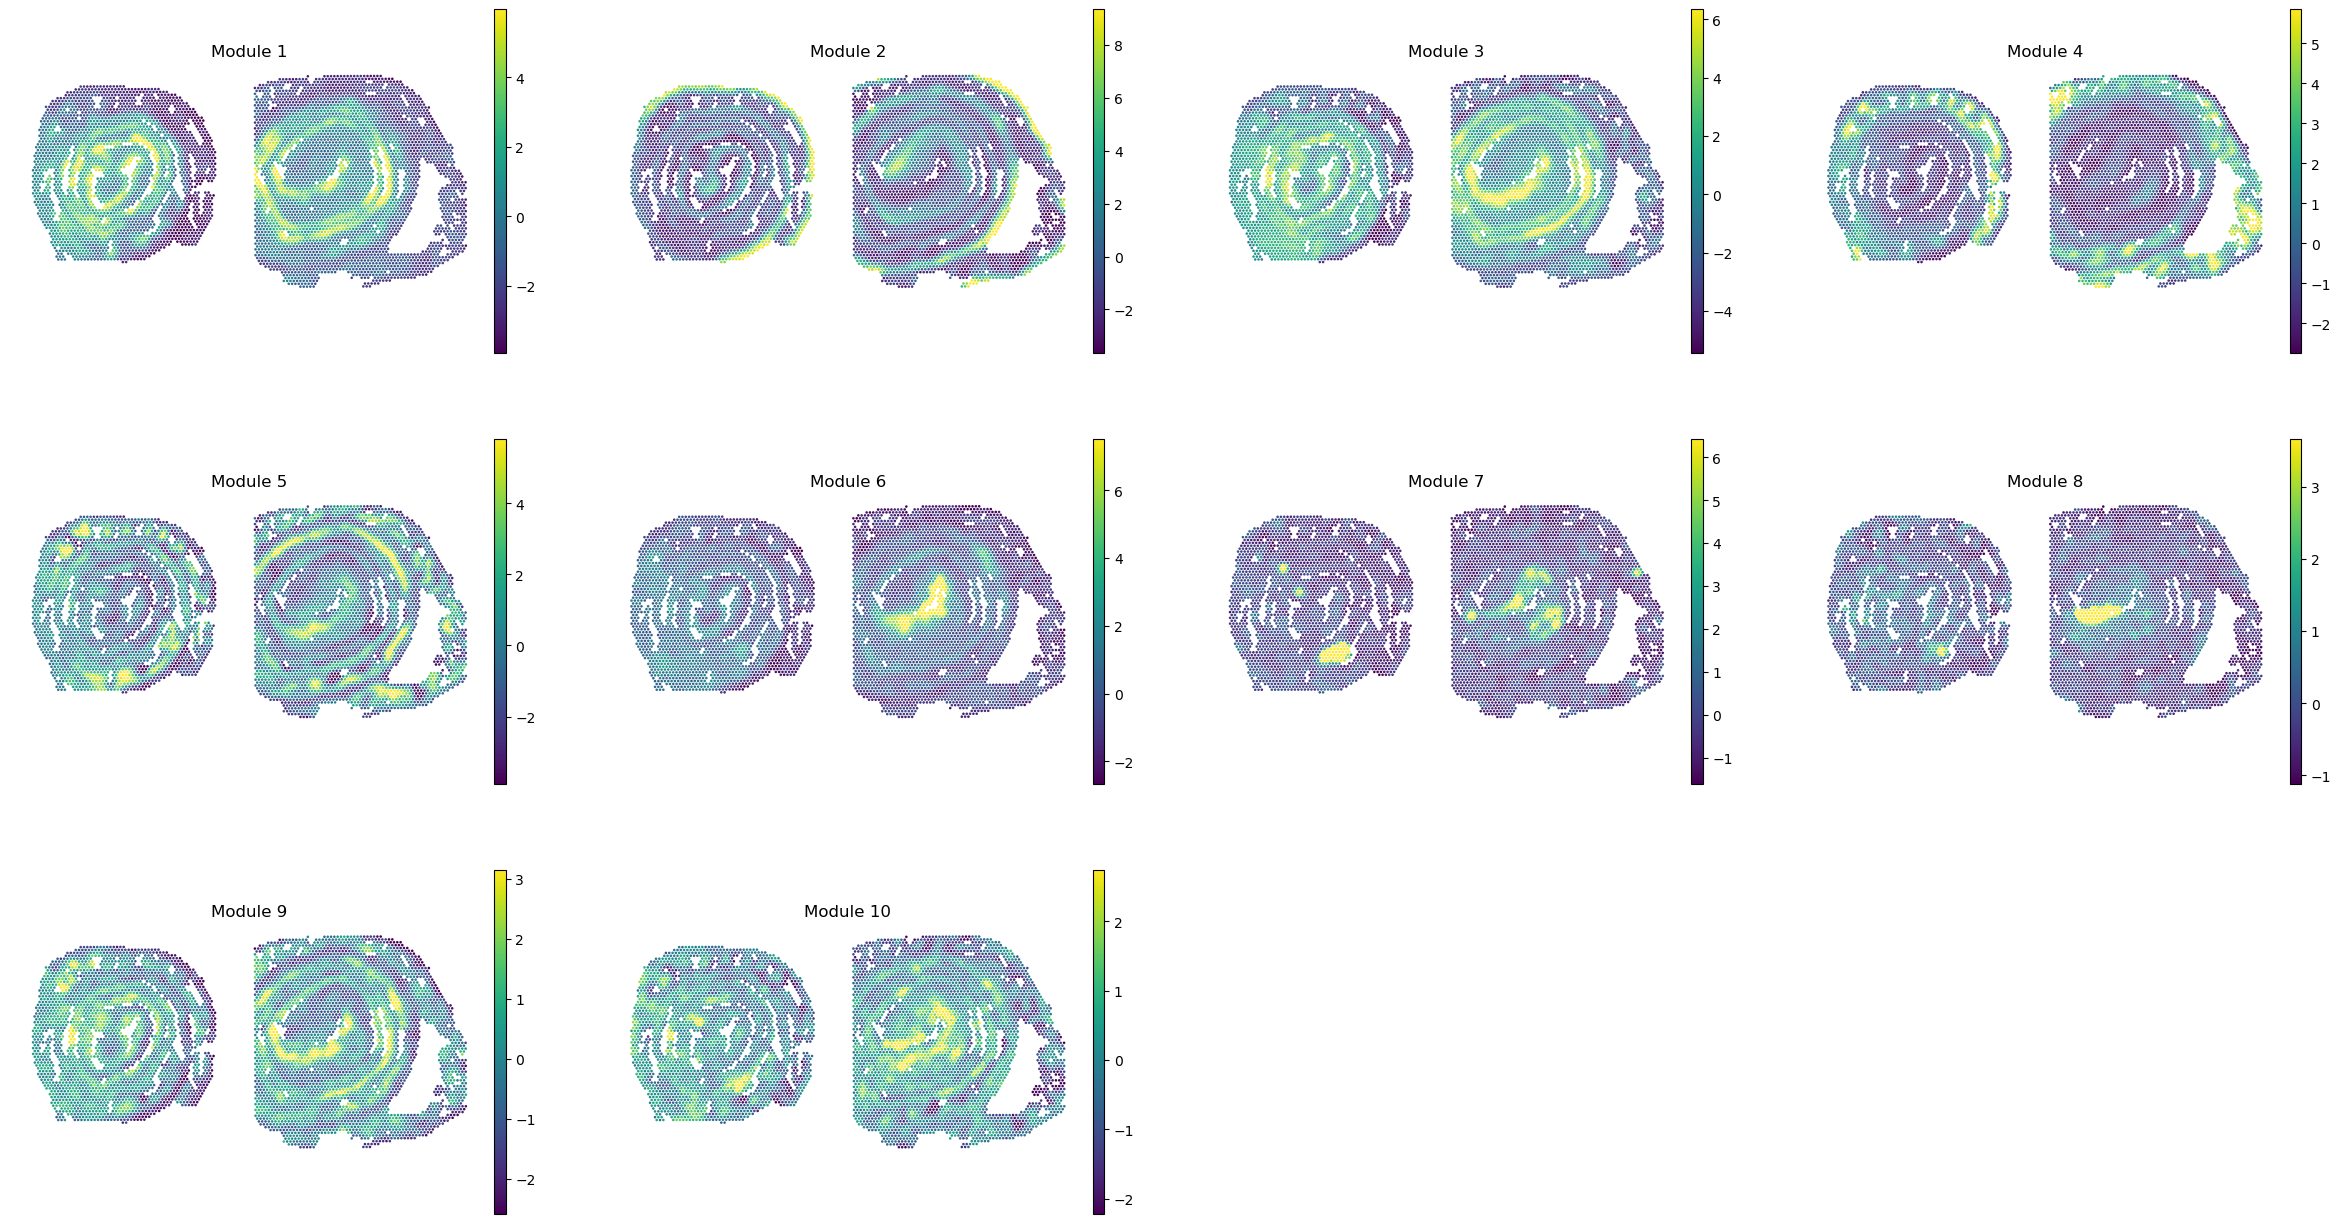

In [14]:
sc.pl.spatial(adata, color=modules, spot_size=80, frameon=False, vmin="p1", vmax="p99", ncols=4, cmap='viridis')

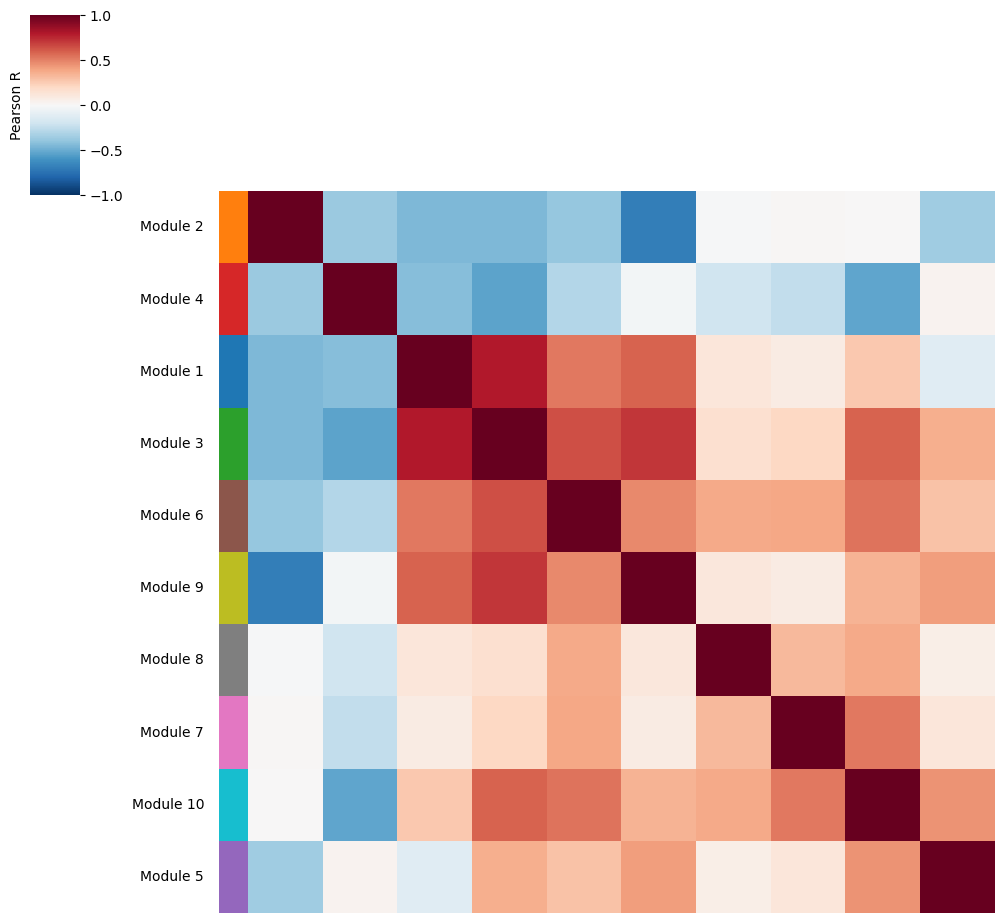

In [15]:
harreman.pl.module_score_correlation_plot(adata, col_cluster=False, row_cluster=False)

In [16]:
# harreman.write_h5ad(adata, os.path.join(ADATA_PATH, 'Visium_colon_Metabolic_Hotspot.h5ad'))

## Comparison with the unrolled results

In [17]:
adata = sc.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_Metabolic_Hotspot.h5ad'))
adata_unrolled = sc.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_Metabolic_Hotspot_unrolled.h5ad'))

In [18]:
gene_modules = adata.uns['gene_modules']
gene_modules_unrolled = adata_unrolled.uns['gene_modules']

module_scores = adata.obsm['module_scores']
module_scores_unrolled = adata_unrolled.obsm['module_scores']

In [19]:
jaccard_sim_matrix = np.zeros((len(gene_modules.keys()), len(gene_modules_unrolled.keys())))
for i in range(len(gene_modules.keys())):
    for j in range(len(gene_modules_unrolled.keys())):
        key_i = list(gene_modules.keys())[i]
        key_j = list(gene_modules_unrolled.keys())[j]
        a = gene_modules[key_i]
        b = gene_modules_unrolled[key_j]
        jaccard_sim_matrix[i,j] = len(list(set(a) & set(b))) / len(list(set(a) | set(b)))
jaccard_sim_matrix_df = pd.DataFrame(jaccard_sim_matrix, index=gene_modules.keys(), columns=gene_modules_unrolled.keys())

In [20]:
correlation_matrix = pd.DataFrame(
    [[module_scores[col1].corr(module_scores_unrolled[col2]) for col2 in module_scores_unrolled.columns] for col1 in module_scores.columns],
    index=module_scores.columns,
    columns=module_scores_unrolled.columns
)

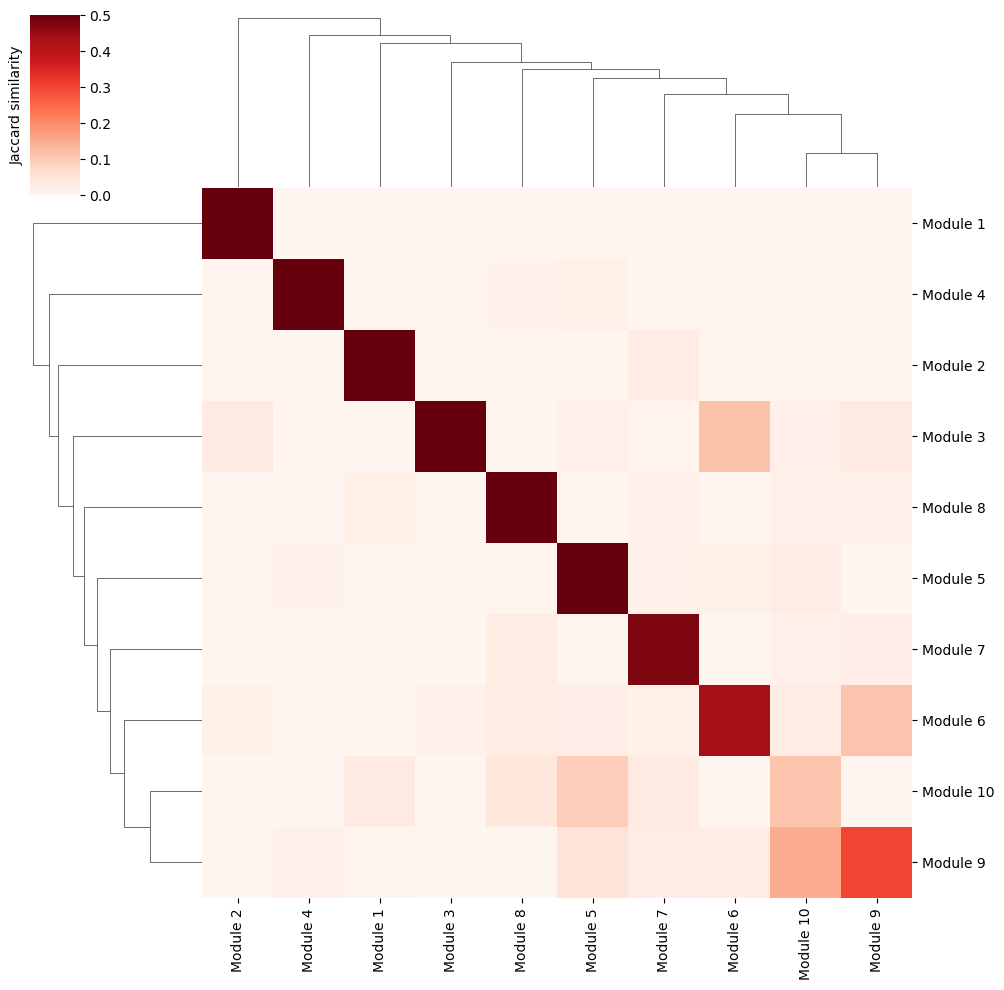

In [21]:
cmap = mpl.colormaps.get_cmap('Reds')
cmap.set_bad("gray")

fig = sns.clustermap(data=jaccard_sim_matrix_df, cmap=cmap, xticklabels=True, yticklabels=True, vmax=0.5)
ax = fig.ax_heatmap
# ax.set_xlabel('Hotspot modules (unrolled coordinates)')
# ax.set_ylabel('Hotspot modules (original coordinates)')

g = plt.gcf()

min_delta = 1e99
min_aa = None
for aa in g.get_children():
    try:
        bbox = aa.get_position()
        delta = (0-bbox.xmin)**2 + (1-bbox.ymax)**2
        if delta < min_delta:
            delta = min_delta
            min_aa = aa
    except AttributeError:
        pass

label = 'Jaccard similarity'
min_aa.set_ylabel(label)
min_aa.yaxis.set_label_position("left")

# plt.savefig(os.path.join(PLOTS_PATH, 'Jaccard_similarity_comparison.svg'))
plt.show()

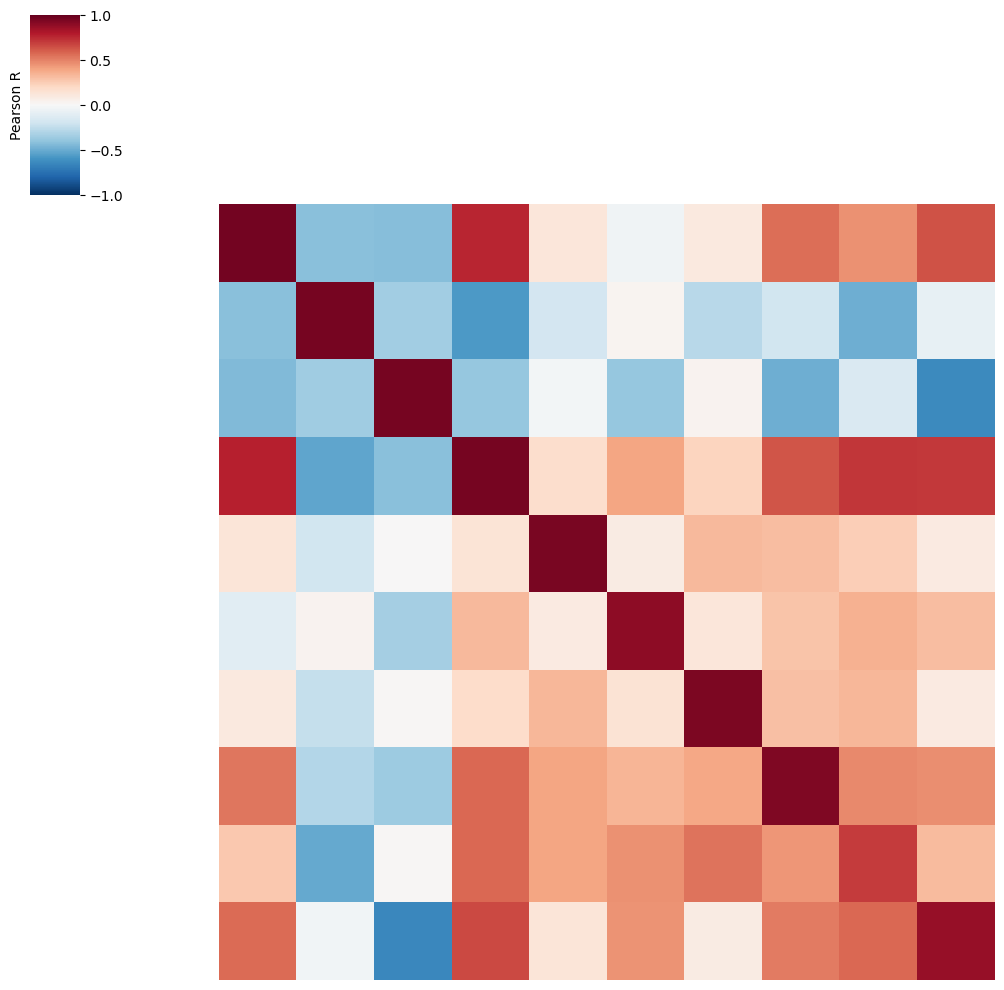

In [22]:
cmap = mpl.colormaps.get_cmap('RdBu_r')
cmap.set_bad("gray")

fig = sns.clustermap(data=correlation_matrix.loc[fig.data2d.index, fig.data2d.columns], cmap=cmap, xticklabels=False, yticklabels=False, row_cluster=False, col_cluster=False, vmin=-1, vmax=1)
ax = fig.ax_heatmap
# ax.set_xlabel('Hotspot modules (unrolled coordinates)')
# ax.set_ylabel('Hotspot modules (original coordinates)')

g = plt.gcf()

min_delta = 1e99
min_aa = None
for aa in g.get_children():
    try:
        bbox = aa.get_position()
        delta = (0-bbox.xmin)**2 + (1-bbox.ymax)**2
        if delta < min_delta:
            delta = min_delta
            min_aa = aa
    except AttributeError:
        pass

label = 'Pearson R'
min_aa.set_ylabel(label)
min_aa.yaxis.set_label_position("left")

# plt.savefig(os.path.join(PLOTS_PATH, 'Pearson_cor_comparison.svg'))
plt.show()